In [1]:
import numpy as np
import cv2
from skimage.segmentation import slic
from skimage import io
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.color as color
from skimage.future import graph
from skimage import feature, transform
from skimage import measure
from skimage import exposure
from skimage.feature import local_binary_pattern
import networkx as nx
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

/home/dzyga/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [28]:
font_dict = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16}

In [3]:
def show_image(img):
    f = plt.figure(figsize=(8, 12))
    plt.imshow(img)
    plt.axis('off');

In [4]:
def masking_image(img, mask):
    dst = img.copy()
    dst[:,:,1] = dst[:,:,1] * mask
    return dst

In [5]:
def weight_boundary(graph, src, dst, n):
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']

    count = count_src + count_dst
    return {
        'count': count,
        'weight': (count_src * weight_src + count_dst * weight_dst)/count
    }

def merge_boundary(graph, src, dst):
    pass

In [6]:
def floor_label(labels):
    """takes the lable value from the central lower part of image"""
    h, w = labels.shape
    potential_floor = labels[int(h/2):, int(w/4):int(w*3/4)]
    
#     fig, ax = plt.subplots(1,2)
#     ax[0].imshow(labels)
#     ax[1].imshow(potential_floor)
    
    # choose the biggest segments 
    unique, counts = np.unique(potential_floor, return_counts=True)
    res_dict = dict(zip(unique, counts))
    main_label = sorted(res_dict.items(), key=lambda kv: kv[1], reverse=True)[0][0]
#     return labels[int(h*0.8), int(w*0.5)]
    return main_label

In [7]:
def weight_histogram(g_edg, percent_thresh = 0.80):
    """plot histogram of RAG edges weights and return threshold for a given percentile"""
    from scipy.stats import percentileofscore
    w_list = list(g_edg.edges(data='weight'))
    weights = np.asarray([w[2] for w in w_list])
    percentile = np.quantile(weights, percent_thresh)
    return percentile

### Loading image

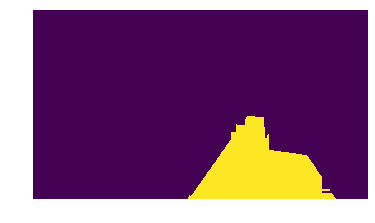

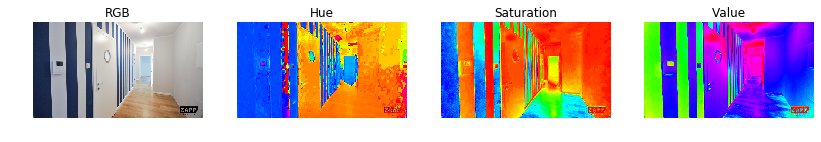

In [8]:
imwrite_result = False #False #True
if imwrite_result:
    import os
    directory = 'result_images/'
    if not os.path.exists(directory):
            os.makedirs(directory)

# file = '4.jpg'
# file = 'img0.png'
# file = './Fwd_ floor segmentation proposal/image1.jpeg'
fname = '70120232_2473173446084559_2338160950193946624_n.jpg'
file = './dataset/' + fname 
file_gt = './dataset/ground_truth/' + fname

# ---- edge map file
# file_ed = 'edgemap5_0.png'
# edges_map = io.imread(file_ed) 
# edges_map = transform.resize(edges_map, (imh, imw))

img = io.imread(file)
img_original = img.copy()

# img = transform.rotate(img, -90)
imh, imw, imc = img.shape
imh_orig = imh
imw_orig = imw
if imh > 600 and imh < 1000: 
    img = transform.resize(img, (int(imh/2), int(imw/2)))
    print('Image shape resized to ', img.shape)
    imh, imw, imc = img.shape
elif imh > 1000:
    img = transform.resize(img, (int(imh/4), int(imw/4)))
    print('Image shape resized to ', img.shape)
    imh, imw, imc = img.shape
    
img_gt = io.imread(file_gt)
img_gt = img_gt[:,:,0]
img_gt[img_gt <= 125] = 0
img_gt[img_gt > 125] = 1

hsvimg = color.rgb2hsv(img)
himg = hsvimg[:,:,0]
simg = hsvimg[:,:,1]
vimg = hsvimg[:,:,2]
gimg = color.rgb2gray(img)
# rgbhsvimg = cv2.merge((img, hsvimg))

plt.figure(), plt.imshow(img_gt), plt.axis('off');

fig, axes = plt.subplots(ncols=4, figsize=(14, 2))
axes[0].imshow(img)
axes[0].set_title('RGB')
axes[0].axis('off')
axes[1].imshow(hsvimg[:,:,0],  cmap='hsv')
axes[1].set_title('Hue')
axes[1].axis('off')
axes[2].imshow(hsvimg[:,:,1],  cmap='hsv')
axes[2].set_title('Saturation');
axes[2].axis('off')
axes[3].imshow(hsvimg[:,:,2],  cmap='hsv')
axes[3].set_title('Value')
axes[3].axis('off');

if imwrite_result: 
    io.imsave('result_images/saturation_img.jpg',simg)

In [1]:
# Histogram equalization
# img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.7)
img_adapteq = exposure.equalize_adapthist(hsvimg, clip_limit=0.3)
# img_adapteq = color.rgb2gray(img_adapteq)
# img_adapteq = exposure.equalize_adapthist(simg, clip_limit=0.3)
# img_adapteq = color.rgb2hsv(img_adapteq)
plt.figure(), plt.imshow(img_adapteq), plt.axis('off');

fig, axes = plt.subplots(ncols=4, figsize=(14, 2))
axes[0].imshow(img_adapteq)
axes[0].set_title('RGB')
axes[0].axis('off')
axes[1].imshow(img_adapteq[:,:,0],  cmap='hsv')
axes[1].set_title('Hue')
axes[1].axis('off')
axes[2].imshow(img_adapteq[:,:,1],  cmap='hsv')
axes[2].set_title('Saturation');
axes[2].axis('off')
axes[3].imshow(img_adapteq[:,:,2],  cmap='hsv')
axes[3].set_title('Value')
axes[3].axis('off');

NameError: name 'exposure' is not defined

### SLIC Superpixels

1.2675975840029423 sec to process
Number of unique labels is  249


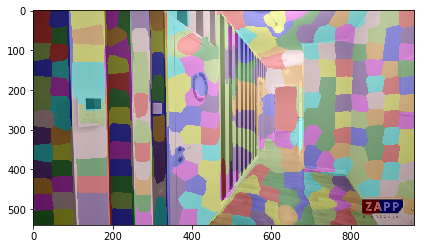

In [10]:
start = timeit.default_timer()
num_segmnts = 300
# labels = slic(rgbhsvimg, n_segments = num_segmnts, sigma = 5, compactness = 0.01)
# labels = slic(himg, n_segments = num_segmnts, sigma = 5, compactness = 0.01)
# labels = slic(img_adapteq, n_segments = num_segmnts, sigma = 5, compactness = 0.01)
labels = slic(img, n_segments = num_segmnts, sigma = 5, compactness = 7)
# labels = slic(hsvimg, n_segments = num_segmnts, sigma = 5, compactness = 7)
# labels = slic(labels_hier_slic, n_segments = 10, sigma = 5, compactness = 1)
# labels = slic(cv2.merge((img[:,:,0], img[:,:,0], img[:,:,0])), n_segments = num_segmnts, sigma = 5, compactness = 7)
stop = timeit.default_timer()
segments = color.label2rgb(labels, img, kind='avg')

# plt.figure(), plt.imshow(segments), plt.axis('off');
io.imshow(color.label2rgb(labels, img)); 
print("{} sec to process".format((stop - start)))

if imwrite_result: 
    io.imsave('result_images/slic_segments.jpg',segments)
    
print('Number of unique labels is ', len(np.unique(labels)))

### RAG and clustering

False


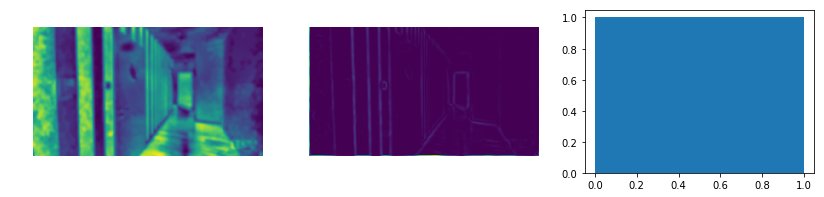

In [11]:
METHOD = 'var' # NaN appears
radius = 5
n_points = 8 * radius
# lbp = local_binary_pattern(simg, n_points, radius, METHOD)
# lbp = local_binary_pattern(filters.gaussian(simg, sigma=15), n_points, radius, METHOD)
# lbp = local_binary_pattern(filters.median(simg), n_points, radius, METHOD)

# edge_map_for_lbp = exposure.equalize_adapthist(simg, clip_limit=0.03)
edge_map_for_lbp = filters.gaussian(exposure.equalize_adapthist(simg, clip_limit=0.03), sigma=5) # No
# edge_map_for_lbp = filters.gaussian(simg,sigma=5) # No
# edge_map_for_lbp = simg

lbp = local_binary_pattern(edge_map_for_lbp, n_points, radius, METHOD)

# Handle missing value
lbp[np.isnan(lbp)] = np.nanmean(lbp)
print(np.isnan(lbp).any())

fig, axis = plt.subplots(1,3, figsize=(14, 3))
axis[0].imshow(edge_map_for_lbp), axis[0].axis('off')
axis[1].imshow(lbp), axis[1].axis('off')
n_bins = int(lbp.max() + 1)
axis[2].hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins));

In [12]:
lbp1 = local_binary_pattern(himg, n_points, radius, METHOD)
lbp2 = local_binary_pattern(simg, n_points, radius, METHOD)
lbp3 = local_binary_pattern(vimg, n_points, radius, METHOD)

In [13]:
lbp2 = local_binary_pattern(simg, n_points, radius, METHOD)
lbp3 = local_binary_pattern(vimg, n_points, radius, METHOD)
lbp = lbp3+lbp2
lbp[np.isnan(lbp)] = np.nanmean(lbp)
x = 5
lbp[:, :x] = np.median(lbp)
lbp[:x, :] = np.median(lbp)
lbp[-x:, :] = np.median(lbp)
lbp[:, -x:] = np.median(lbp)

# lbp[lbp<np.max(lbp)/10] = 0
# lbp[lbp>=np.max(lbp)/10] = 1
# tmp = feature.canny(lbp)


show_image(lbp)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


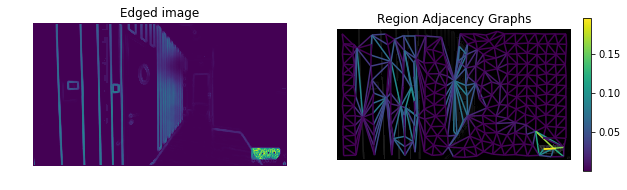

In [14]:
# Edge map
# edges = filters.sobel(simg)
# edges = filters.sobel(img_adapteq[:,:,0])
edges = lbp
# edges = edges_map
edges_rgb = color.gray2rgb(edges)

# Graph 
g_edg = graph.rag_boundary(labels, lbp, connectivity=2)

fig, axes = plt.subplots(1,2, figsize=(10, 8), sharey=True)
axes[0].set_title('Edged image')
axes[0].imshow(edges)
axes[0].axis('off')
axes[1].set_title('Region Adjacency Graphs')
lc = graph.show_rag(labels, g_edg, edges_rgb, img_cmap=None, edge_cmap='viridis', ax=axes[1])
axes[1].axis('off')
fig.colorbar(lc, fraction=0.03);

if imwrite_result: 
    io.imsave('result_images/edge_map.jpg',edges)

Was 0.035, but now is  0.008243835907358797


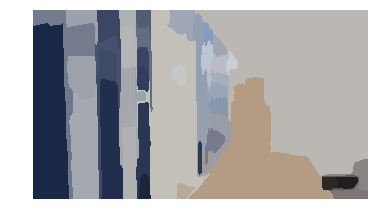

In [15]:
start = timeit.default_timer()
w_list = list(g_edg.edges(data='weight'))
weights = np.asarray([w[2] for w in w_list])
Q = np.quantile(weights, 0.70)
print('Was 0.035, but now is ', Q)
labels_hier_slic = graph.merge_hierarchical(labels, g_edg, Q, rag_copy=True,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

stop = timeit.default_timer()
# print("{} sec to process".format((stop - start)))

hierarchical_slic = color.label2rgb(labels_hier_slic, img, kind='avg')
plt.figure(), plt.imshow(hierarchical_slic)
plt.axis('off');

if imwrite_result: 
    io.imsave('result_images/hierarchical_merged.jpg',hierarchical_slic)

In [26]:
true_lable = floor_label(labels_hier_slic)

(540, 960)

# Result

In [17]:
h, w = labels.shape
potential_floor = labels[int(h/2):, int(w/4):int(w*3/4)]
# show_image(potential_floor)
# choose the biggest segments 
unique, counts = np.unique(potential_floor, return_counts=True)
res_dict = dict(zip(unique, counts))
main_label = sorted(res_dict.items(), key=lambda kv: kv[1], reverse=True)[0][0]
sorted(res_dict.items(), key=lambda kv: kv[1], reverse=True)
main_label

149

In [18]:
target_label = floor_label(labels_hier_slic)
mask = np.zeros(labels_hier_slic.shape, dtype=np.float32)
mask[labels_hier_slic == target_label] = 1

dst = img.copy()
dst[:,:,1] = dst[:,:,1] * (1-mask)

cv2.putText(dst, "{:.4f}".format(Q), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 3, cv2.LINE_AA)
show_image(dst)

if imwrite_result: 
    io.imsave('result_images/result.jpg',transform.rotate(dst, -90))
    
# plt.gcf().canvas.mpl_connect('button_press_event', onclick);

In [19]:
im_stack = np.hstack((img, dst)) #stacking images side-by-side
h, w, c = im_stack.shape

font = cv2.FONT_HERSHEY_SIMPLEX 
fontScale = 3
text_color = (255, 0, 0) 
thickness = 6

text1 = 'before'
org1 = (int(w/5), int(h/4)) 
cv2.putText(im_stack, text1, org1, font,  
                   fontScale, text_color, thickness, cv2.LINE_AA)
text2 = 'after'
org2 = (int(3*w/4), int(h/4)) 
cv2.putText(im_stack, text2, org2, font,  
                   fontScale, text_color, thickness, cv2.LINE_AA); 

# show_image(im_stack)

### Evaluation

In [20]:
if dst.shape[0] != imh_orig:
    mask = transform.resize(mask, (imh_orig, imw_orig))
    mask[mask <= 0.5] = 0
    mask[mask > 0.5] = 1
    
def iou_evaluation(mask, img_gt):
    return np.sum(mask * img_gt) /  np.sum(mask+img_gt) # ?? 

iou = np.logical_and(mask, img_gt).sum() / np.logical_or(mask, img_gt).sum()
iou

0.7823271613363056

### Graph analyzing

In [21]:
from scipy.stats import percentileofscore
w_list = list(g_edg.edges(data='weight'))
weights = np.asarray([w[2] for w in w_list])
print(np.quantile(weights, 0.80))
print(percentileofscore(weights, 0.035))

0.022833478123035267
83.85650224215247


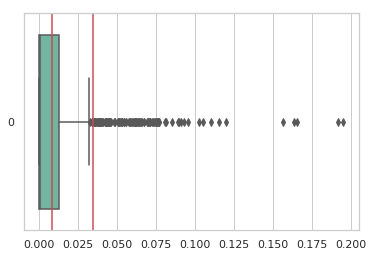

<Figure size 432x288 with 0 Axes>

In [22]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(data=weights, orient="h", palette="Set2")
plt.axvline(Q, color='r');
plt.axvline(0.035, color='r');

hist, bins = np.histogram(weights, bins = int(len(weights)/10))
plt.figure();

In [23]:
def histogram_plotting(g_edg):
    w_list = list(g_edg.edges(data='weight'))
    weights = np.asarray([w[2] for w in w_list])
    hist = plt.hist(weights, bins = int(len(weights)/10), normed=0)
    plt.xlim(0, 0.05)
    plt.axvline(Q, color='r');
    fig1 = plt.gcf()
    plt.draw()
    
    
histogram_plotting(g_edg)   

/home/dzyga/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


1
Area is  63742.5
Perimiter is  1431.394004225731


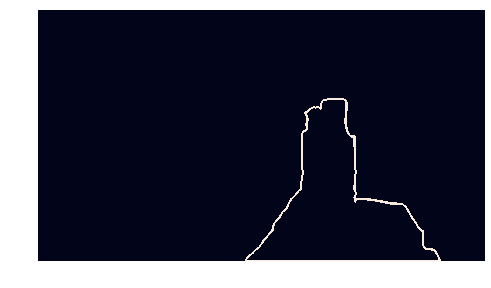

In [24]:
from numpy import random
contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(mask),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
print(len(contours))

mask_interp = np.zeros_like(mask)
for cnt in contours: 
    print('Area is ', cv2.contourArea(cnt))
    print('Perimiter is ', cv2.arcLength(cnt,True))      
    cv2.drawContours(mask_interp, cnt, -1, random.rand(3), 3)
show_image(mask_interp)

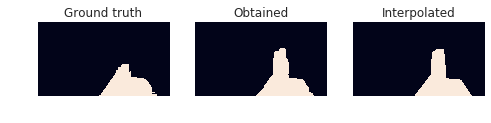

In [25]:
mask_interp = np.zeros_like(mask)
    
# Max contour
areas = []
for cnt in contours:
    areas.append(cv2.contourArea(cnt))    
true_contour = contours[np.argmax(areas)]
cv2.drawContours(mask_interp, true_contour, -1, random.rand(3), 3)

# kernel = np.ones((2,2), np.uint8)
# mask_interp = cv2.dilate(mask_interp, kernel, iterations = 3)
# cv2.fillPoly(mask_interp, true_contour, color=(255,255,255))

# contour approx
epsilon = 0.01*cv2.arcLength(true_contour, True)
approx = cv2.approxPolyDP(true_contour, epsilon, True)

cv2.fillPoly(mask_interp, [approx], color=(255,255,255))

# show_image(mask_interp)
    
# Hull 
# for cnt in contours:
#     hull = cv2.convexHull(cnt)
#     cv2.drawContours(mask_interp, [hull], -1, (255, 255, 255), -1)
#     cv2.fillPoly(mask_interp, [hull], color=(255,255,255))
    
# hull = cv2.convexHull(true_contour)
# cv2.fillPoly(mask_interp, [hull], color=(255,255,255))

# defects = cv2.convexityDefects(true_contour,hull)

# for i in range(defects.shape[0]):
#     s,e,f,d = defects[i,0]
#     start = tuple(true_contour[s][0])
#     end = tuple(true_contour[e][0])
#     far = tuple(true_contour[f][0])
#     cv2.line(mask_interp,start,end,[0,255,0],2)
#     cv2.circle(mask_interp,far,5,[0,0,255],-1)
# show_image(mask_interp)

fig, ax = plt.subplots(1,3, figsize = (8,12))
ax[0].imshow(img_gt)
ax[0].set_title('Ground truth')
ax[0].axis('off')
ax[1].imshow(mask)
ax[1].set_title('Obtained')
ax[1].axis('off')
ax[2].imshow(mask_interp)
ax[2].set_title('Interpolated')
ax[2].axis('off');